# Amazon Review - Downsampled vs Full Dataset

Re-running our initial EDA on the full Amazon Review on the full dataset. Since we down-sampled our data to 100k samples for our first datset, we are going to run the same analysis to make sure we did not introduce bias because of our sampling method.

We will graph our orignal EDA notebook graphs side by side with the same graphs generated using our full dataset

# Conclusion

* Same
    * Star rating review distribution (ie, 1-star... 5-star)
    * Number of review per month and day of week
* Different
    * Unique Products - when we downsample, we have 50% of the reviews are for unique product. However, when looking at full dataset, only 9% of our review are for unique products - this is actually ok since we are generally just looking at the review independent of the production so this should not affect our models

In [1]:
# import sibling utilities
import sys
sys.path.append('../..')

import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)
import logging

logging.basicConfig(level=logging.INFO)

import util.file_util as fu

import sys,os,os.path
DEBUG = bool(os.environ.get("IPYNB_DEBUG", False))

# global variables
COLUMNS_TO_DROP=["marketplace", "vine", "verified_purchase"]
USE_PANDAS=True
SEPERATOR=","

DATA_DIR = "../../dataset/amazon_reviews"

# full 9mil Wireless reviews - not enough memory locally to do this
ORIG_FILE_WIRELESS=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00.tsv"


# Read in our pre-processed File

In [2]:
DATA_FILE_100k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-100k.csv"
DATA_FILE_50k=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-50k.csv"
DATA_FILE_ALL=f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-all.csv"


DATA_FILE=DATA_FILE_ALL


# Load Data File

In [3]:
reviews = pd.read_csv(DATA_FILE, sep=SEPERATOR, 
                         parse_dates=["review_date"])

reviews_100k = pd.read_csv(DATA_FILE_100k, sep=SEPERATOR, 
                         parse_dates=["review_date"])
reviews.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9002021 entries, 0 to 9002020
Data columns (total 15 columns):
marketplace          object
customer_id          int64
review_id            object
product_id           object
product_parent       int64
product_title        object
product_category     object
star_rating          int64
helpful_votes        int64
total_votes          int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(9)
memory usage: 1.0+ GB


In [4]:
# looks like sometimes we have reviews with no body, no headline, and no review dates
# let's drop those rows with missing data
# also drop the following columns since they will always be the same
clean_df = reviews.dropna().drop(COLUMNS_TO_DROP, axis = 1)

clean_df_100k = reviews_100k.dropna().drop(COLUMNS_TO_DROP, axis = 1)

clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9001393 entries, 0 to 9002020
Data columns (total 12 columns):
customer_id         int64
review_id           object
product_id          object
product_parent      int64
product_title       object
product_category    object
star_rating         int64
helpful_votes       int64
total_votes         int64
review_headline     object
review_body         object
review_date         datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 892.8+ MB


## Most Products Only have 1 or 2 reviews

We have less unique products (percentage-wise) when we look at our full dataset.

With our downsampled dataset, 50% of our reviews are for unique products vs when looking at the entire dataset only about 9% of our 9 million reviews are for unique Products.

You also see that changes of a product have multiple reviews increases since there is less of a chance the review is for a unique product.

In [5]:
# how many products do we have?
grouped_100k = clean_df_100k.groupby("product_parent")

grouped = clean_df.groupby("product_parent")


Downsampled 100k: There are (50182 unique products out of 100008) - 50%
There are (767781 unique products out of 9001393) - 9%


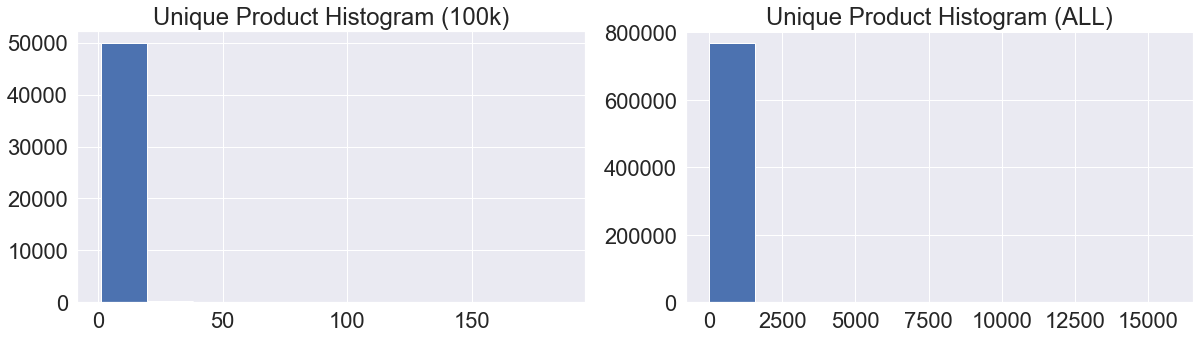

In [6]:
unique_products_100k = len(grouped_100k)
unique_product_percentage_100k = round(unique_products_100k / len(clean_df_100k) * 100)
print(f"Downsampled 100k: There are ({unique_products_100k} unique products out of {len(clean_df_100k)}) - {unique_product_percentage_100k}%")

unique_products = len(grouped)
unique_product_percentage = round(unique_products / len(clean_df) * 100)
print(f"There are ({unique_products} unique products out of {len(clean_df)}) - {unique_product_percentage}%")


f, a = plt.subplots(1, 2, figsize=(20, 5))

grouped_100k.size().hist(ax=a[0])
_ = a[0].set_title("Unique Product Histogram (100k)")

grouped.size().hist(ax=a[1])
_ = a[1].set_title("Unique Product Histogram (ALL)")


In [7]:
quantile_list = [0., .25, .75, 1.]

quantiles_100k = grouped_100k.size().quantile(quantile_list)
print(quantiles_100k)

quantiles = grouped.size().quantile(quantile_list)
quantiles

0.00      1.0
0.25      1.0
0.75      2.0
1.00    186.0
dtype: float64


0.00        1.0
0.25        1.0
0.75        4.0
1.00    15767.0
dtype: float64

In [8]:
# trying some type of binning - 100k
products_df_100k = pd.DataFrame(grouped_100k.size(), columns=["count"])
products_df_100k = products_df_100k.assign(bin=lambda x: pd.cut(x["count"], [0, 1, 2, 3, x["count"].max()]))

product_review_df_100k = pd.DataFrame(products_df_100k.groupby("bin").size(), columns=["count"]).reset_index()
product_review_df_100k["percent"] = product_review_df_100k["count"] / product_review_df_100k["count"].sum() * 100
print(f'Products Binned by Number of Reviews (100k):\n{product_review_df_100k}')


# trying some type of binning - ALL
products_df = pd.DataFrame(grouped.size(), columns=["count"])
products_df = products_df.assign(bin=lambda x: pd.cut(x["count"], [0, 1, 2, 3, x["count"].max()]))

product_review_df = pd.DataFrame(products_df.groupby("bin").size(), columns=["count"]).reset_index()
product_review_df["percent"] = product_review_df["count"] / product_review_df["count"].sum() * 100
print(f'\n\nProducts Binned by Number of Reviews (ALL):\n{product_review_df}')





INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Products Binned by Number of Reviews (100k):
        bin  count    percent
0    (0, 1]  36160  72.057710
1    (1, 2]   6583  13.118250
2    (2, 3]   2710   5.400343
3  (3, 186]   4729   9.423698


Products Binned by Number of Reviews (ALL):
          bin   count    percent
0      (0, 1]  392910  51.174749
1      (1, 2]  111176  14.480171
2      (2, 3]   54452   7.092127
3  (3, 15767]  209243  27.252954


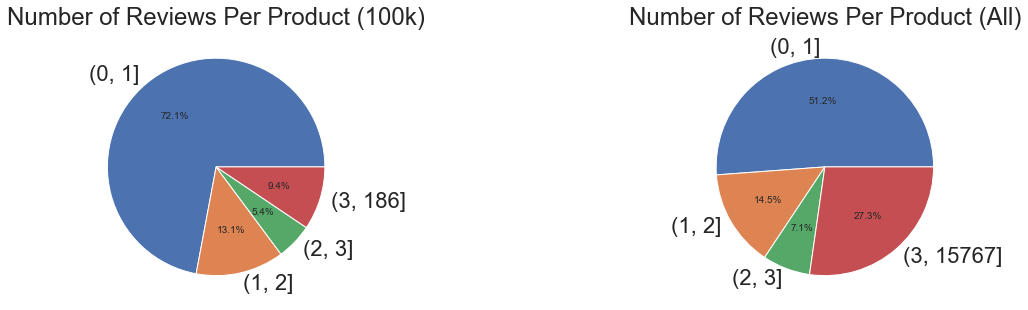

In [9]:
f, a = plt.subplots(1, 2, figsize=(20, 5))

_ = a[0].pie(product_review_df_100k.percent, labels=product_review_df_100k.bin, autopct='%1.1f%%')
_ = a[0].set_title("Number of Reviews Per Product (100k)")


_ = a[1].pie(product_review_df.percent, labels=product_review_df.bin, autopct='%1.1f%%')
_ = a[1].set_title("Number of Reviews Per Product (All)")


# Reviews By Month and Days

* Distribution of reviews by month is roughly the same between downsampled (100k) and full data set

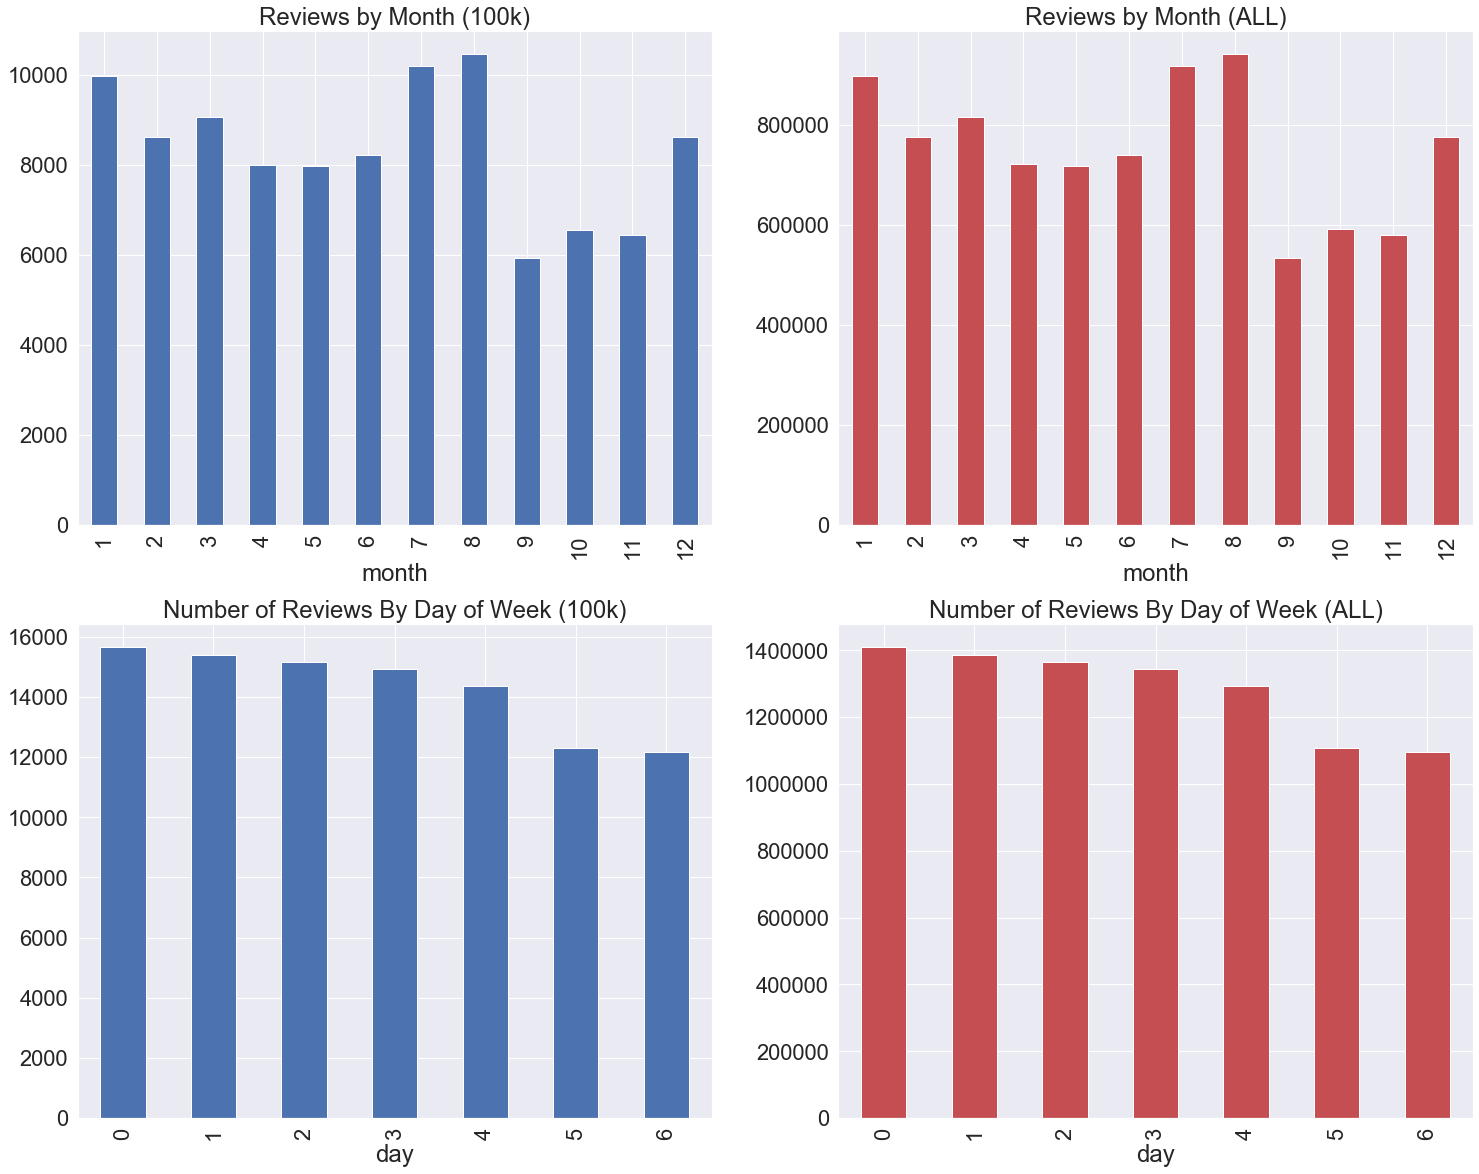

In [10]:
f, a = plt.subplots(2, 2, figsize=(25, 20))

# distribution of months
df_100k = clean_df_100k
df_100k["month"] = df_100k.review_date.dt.month
df_100k.groupby("month").size().plot(kind='bar', ax=a[0][0])
a[0][0].set_title("Reviews by Month (100k)")


df = clean_df
df["month"] = df.review_date.dt.month
df.groupby("month").size().plot(kind='bar', ax=a[0][1], color="r")
a[0][1].set_title("Reviews by Month (ALL)")

# distribution by day of week
df_100k = clean_df_100k
df_100k["day"] = df_100k.review_date.dt.dayofweek
df_100k.groupby("day").size().plot(kind='bar', ax=a[1][0])
_ = a[1][0].set_title("Number of Reviews By Day of Week (100k)")

df = clean_df
df["day"] = df.review_date.dt.dayofweek
df.groupby("day").size().plot(kind='bar', ax=a[1][1], color="r")
_ = a[1][1].set_title("Number of Reviews By Day of Week (ALL)")

# Star Rating Distribution

Distribution of star ratings are roughly the same between downsampled (100k) and full dataset

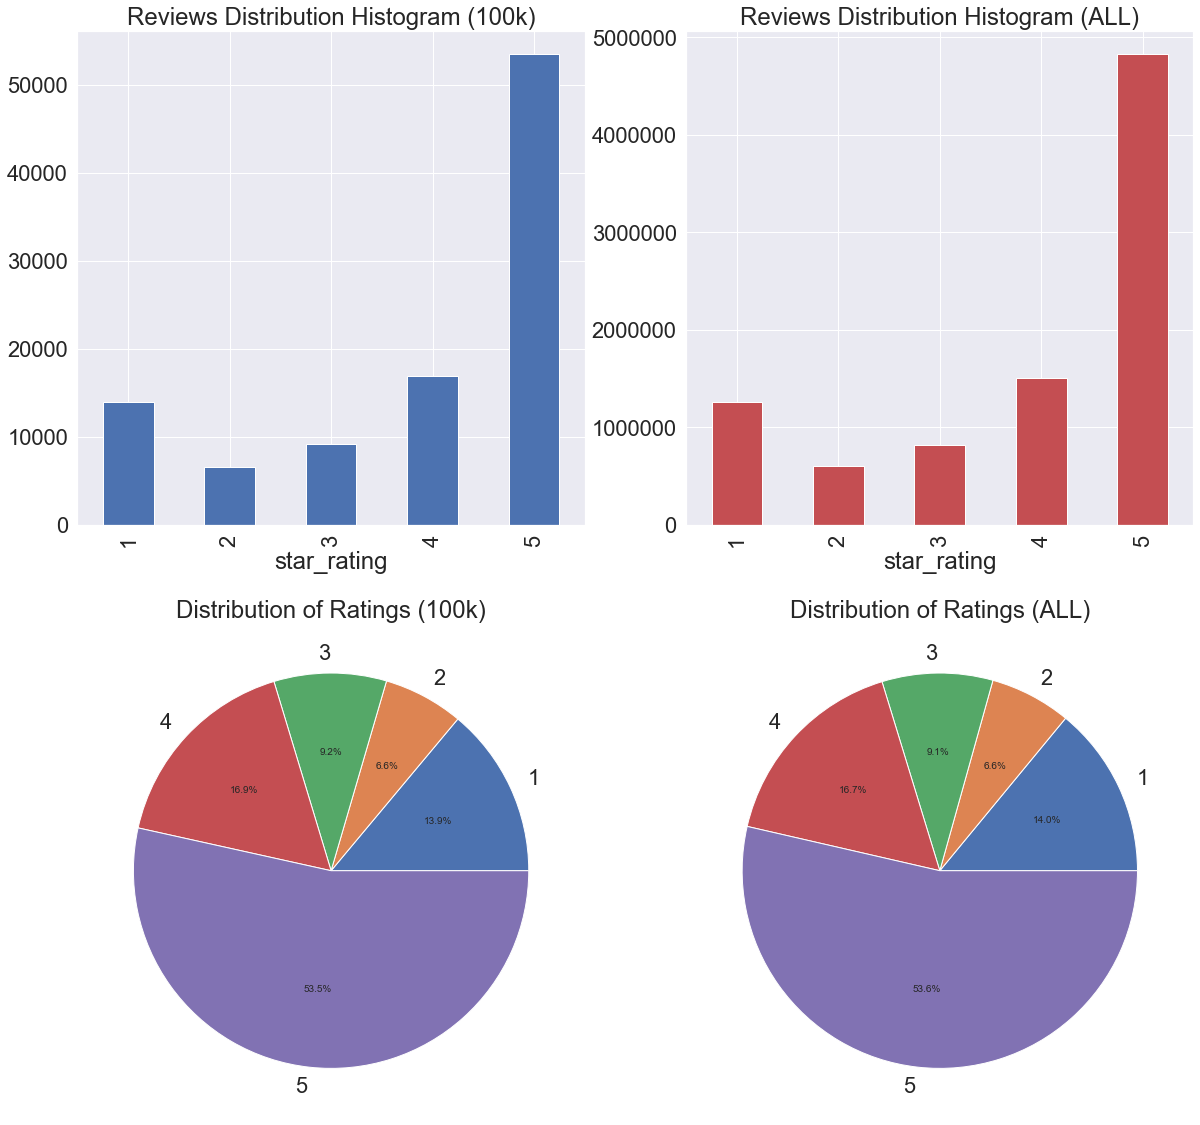

In [11]:
f, a = plt.subplots(2, 2, figsize=(20, 20))

# let's look at distribution of stars
_ = clean_df_100k.groupby("star_rating").size().plot(kind='bar', ax=a[0][0])
_ = a[0][0].set_title("Reviews Distribution Histogram (100k)")


_ = clean_df.groupby("star_rating").size().plot(kind='bar', ax=a[0][1], color="r")
_ = a[0][1].set_title("Reviews Distribution Histogram (ALL)")
# reviews lean heavily towards 5-stars

ratings_summary_100k = pd.DataFrame(clean_df_100k.groupby("star_rating").size(), columns=["count"]).reset_index()
ratings_summary_100k["percent"] = ratings_summary_100k["count"] / ratings_summary_100k["count"].sum() * 100


ratings_summary = pd.DataFrame(clean_df.groupby("star_rating").size(), columns=["count"]).reset_index()
ratings_summary["percent"] = ratings_summary["count"] / ratings_summary["count"].sum() * 100

# clean_df.groupby("star_rating").size().apply(lambda x: 100 * x / float(x.sum()))

_ = a[1][0].pie(ratings_summary_100k.percent, labels=ratings_summary.star_rating, autopct='%1.1f%%')
_ = a[1][0].set_title("Distribution of Ratings (100k)")

_ = a[1][1].pie(ratings_summary.percent, labels=ratings_summary.star_rating, autopct='%1.1f%%')
_ = a[1][1].set_title("Distribution of Ratings (ALL)")

In [12]:
print(datetime.now())

2020-02-01 16:36:13.222818
